> # Neural Network Basic - Week3 과제


## Import Library

In [82]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [83]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [84]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [85]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1 / (1 + np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return x * (1 - x)

In [86]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.max(x, 0)
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        x[x <= 0] = 0
        return x

In [87]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [88]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [89]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [90]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr #learning rate. parameter에 gradient를 얼마나 반영할 지 결정한다.
        self.epoch = epoch  #epoch. 전체 배치를 이용해 학습시키는 횟수.
        self.batch_size = batch_size #batch size. 1회 학습 시 한 번에 처리되는 input data의 개수로, data 1개가 행벡터라면 input matrix 행의 크기이다.
        self.loss_function = cross_entropy #loss function은 cross entropy.
        self.layers = [] #이곳에 CustomNet에 쌓을 Layer가 순서대로 추가된다.
        self.activations = [softmax] #activation function은 기본적으로 softmax이며, 이곳에 순서대로 각 Layer에 해당하는 Activation layer가 추가된다.
        self.nodes = [] #각 layer 사이에 대응되는 노드의 값이 저장되는데, 이는 역전파를 계산할 때 사용된다.
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) #layer를 추가하고
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size)) #node가 없을 경우 추가한다.
        self.nodes.append(np.zeros(Layer.output_size)) #각 layer에 대응하는 node를 추가한다.
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() #activation의 마지막 원소를 뗀다.
        self.activations.append(Activation) #parameter로 투입한 Activation function을 넣는다.
        self.activations.append(tmp) #떼었던 원소를 붙인다.

        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() #self.node에 해당 X를 추가한다.
        output = X.copy() #초기 output 값은 X값으로 초기화한다.
        for i in range(len(self.layers)): 
            Layer = self.layers[i] #model의 self.layers에 저장된 각 Layer마다
            Activation = self.activations[i] #대응되는 Activation이 있어
            output = np.dot(self.nodes[i], Layer.weight) #output은 해당 Layer에 투입된 node input에 weight을 내적하는 linear layer를 지난 후 
            output = output+ Layer.bias #해당 Layer의 bias를 더하여
            output = Activation.forward(output) #Activation function을 통과하고,
            self.nodes[i+1] = output #다음 node의 값은 activation을 통과한 output이 된 뒤
            #위의 과정이 매 layer마다 반복된다.
        return output   #_forward 함수는 모든 layer마다 linear -> bias -> activation 순서로 통과한 결과이다.
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): #역전파이므로 self.layer의 순서를 역으로 뒤집는다.
            a = self.nodes[i+1] #순전파 시 다음 층의 output 값.
            Layer = self.layers[i] #Layer는 해당하는 계층의 layer.
            Activation = self.activations[i] #Activation 또한 해당하는 계층의 actiavtion.
            
            if i+1 == len(self.layers): #역전파 첫 단계에서는
                error = Activation.backward(output, y)#순전파에서의 마지막 activation이 softmax이므로 error도 softmax 함수에 대응하는 error이며, 이 값이 error의 초깃값이다.
            else:
                error *= Activation.backward(a)#각 계층의 activation에서 계산되는 추가 파라미터가 거듭 곱해진다.
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] #각 layer는 loss에 대한 gradient에 learning rate를 곱한 만큼 update되며
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0] #각 bias 또한 그렇다.
            error = np.dot(error, Layer.weight.T) #그 다음 역전파(순전파의 이전 계층)에 흘러가는 gradient(error term)은 layer의 weight에 기존 error를 내적한 결과다.
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) #pre_p는 output(확률벡터) 가운데 가장 값이 높은 클래스의 인덱스이다.
        return np.sum(pre_p==y)/y.shape[0] #전체 Ground Truth 가운데 인덱스가 곧 Ground Truth인, 즉 정답을 맞춘 비율인 Recall 값을 Accuracy로 한다.
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []} #콘솔창에 출력할 메세지.
        N = X.shape[0] #N: 데이터의 수
        for i in range(self.epoch):#각 에포크마다
            for j in range(N//self.batch_size): #각 batch마다
                batch_mask = np.random.choice(N, self.batch_size) #N개 중 batch_size만큼을 임의추출하여
                X_batch = X[batch_mask] #batch의 X와
                y_batch = y[batch_mask] #batch의 y를 추출하고
                output = self._forward(X_batch) #순전파는 batch 단위에 대한 순전파로,
                self._backward(X_batch, output, y_batch) #역전파도 batch 단위에 대한 역전파로 한다.
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) #validation set에 대해 순전파를 진행하여
            history["val_acc"].append(self._accuracy(output, val_y)) #validation set에 대한 accuracy,
            history["val_loss"].append(sum(self.loss_function(output, val_y))) #validation set에 대한 loss를 계산한다.
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [91]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=50, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [92]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [93]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1028
0 test loss     : 23058.018838136817
10 test accuracy : 0.1135
10 test loss     : 22894.0568029799
20 test accuracy : 0.1204
20 test loss     : 22716.216994967184
30 test accuracy : 0.1467
30 test loss     : 22327.482766801622
40 test accuracy : 0.2321
40 test loss     : 21441.119696744183


## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

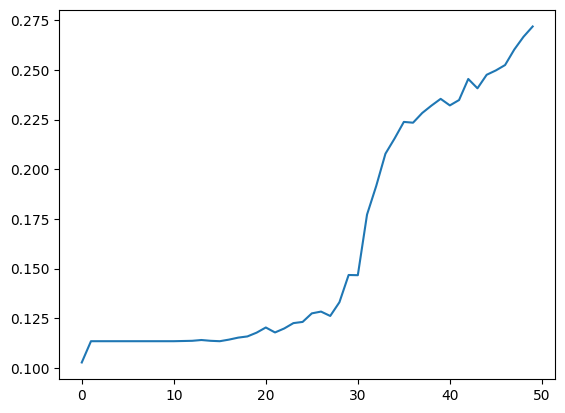

In [111]:
x = np.arange(0, 50)
accuracy = np.array(list(history.values())[0])
plt.plot(x, accuracy)

#에포크를 늘리고, learning rate를 더 감소시키는 기법을 사용하면 성능을 더 개선시킬 수 있을 것으로 생각한다.

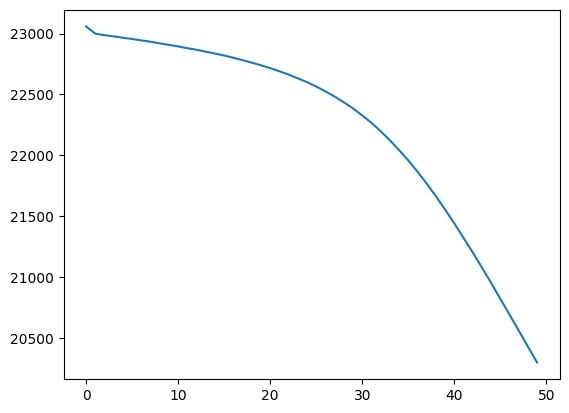

In [112]:
x = np.arange(0, 50)
loss = np.array(list(history.values())[1])
plt.plot(x, loss)